In [2]:
# dans ce code on cherche à définir plusieurs zones à une échéance fixe
# import sklearn.metrics
import numpy as np
import glob
import xarray as xr 
import matplotlib.pyplot as plt
from collections import namedtuple
import pandas as pd
import time
import glob
import sys, os
from pathlib import Path # pour windows 
sys.path.insert(0, os.path.abspath('./lib'))

from lib import read_xarray, find_neighbours,create_new_mask, conversion
from lib import hss,precision,far,f1, pod
from lib import create_combination_subzones, create_nc_mask_NSEO
from lib import group_masks_size, get_optimal_subzone, select_group_mask, get_WME_legend


In [3]:
def get_not_included_masks(mask_temp, list_id,ds_mask,flag_strictly_included=True):
    '''
        return: ensemble des combinaisons de zones sans celles incluses dans mask_temp. 
        flag_strictly_included = True si on supprime seulement les zones qui sont incluses dans mask_temp 
                               = False si on supprime aussi les zones qui ont une zone sympo incluse dans mask_temp
                                Ne peut pas être appliqué si les zones sympos sont placées de manière circulaire 
                                (ex de l'hérault: si la première cible touche la zone 4 alors on supprime tout car la zone 4 touche toutes les autres zones)
    '''    
    lst_mask_not_included = [] # not included in zone_temp
    lst_mask_strict_included = [] # zones included in zone_temp
    for id in list_id:
        mask2compare = ds_mask.mask.sel(id = id)  
        somme = np.sum((mask_temp.values ==1) & (mask2compare.values==1)) 
        taille2 = np.sum(mask2compare.values==1)
        taille1 = np.sum(mask_temp.values==1)
        if somme == taille2 :
            lst_mask_strict_included.append(id)
    print(len(list_id))

    lst_temp = []
    if not flag_strictly_included:
        for zone in list_id:
            for zone_included in lst_mask_strict_included:       
                if zone_included in zone:
                    lst_temp.append(zone)
                else: 
                    pass
        lst_mask_not_included_finale = [element for element in list_id if element not in lst_temp]            
    else: 
        lst_mask_not_included_finale = [element for element in list_id if element not in lst_mask_strict_included]  
    return lst_mask_not_included_finale,  lst_mask_strict_included

def distance(ds,name,**options):
    """calculate the distance between all possible temps sensibles (wme) and the temps sensibles of the zone"""
    
    if name == "compas":
        fname_dist = '../../utils/distance_compas.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')
        var_name="wme_arr"
        varsh="wme_c_"
        
    elif name == "agat":
        fname_dist = '../../utils/distance_agat.csv'
        df_dist = pd.read_csv(fname_dist,sep=',')  
        var_name="w1_arr"
        varsh="w1_c_"
    
        
    if options.get("action") == "test":
        """used to test over few pixels only in debug mode"""
        for iwme,wme in enumerate(df_dist):
            if iwme>0 and iwme<5:
                # initialize ds["1"] etc
                ds[wme]=ds.wme_arr
                for iiwme,wwme in enumerate(df_dist):
                    if iiwme>0:
                        #print(wme,wwme,iiwme,iwme)
                        #print(df_dist.iloc[iiwme-1,iwme])
                        # for a given wme (e.g. "1") every value in ds["1"] is replaced by the ditance btw wme and wwme
                        ds[wme]=ds[wme].where(ds.wme_arr!=int(wwme),df_dist.iloc[iiwme-1,iwme])  
                        
    else:
        for iw,w in enumerate(df_dist): 
            if iw>0:
                ds[varsh+w]=ds.wme_arr
                for iiw,ww in enumerate(df_dist):
                    if iiw>0:
                        ds[varsh+w]=ds[varsh+w].where(ds[var_name]!=int(ww),df_dist.iloc[iiw-1,iw])       
                    
    return ds  

def shortest_distance_temps_sensible_Mary(ds,name):
    '''
        modification de la fonction de Gabriel pour l'avoir à une échéance fixe
    '''   
    if name=="compas": 
        varsh="wme_c_"
    elif name=="agat": 
        varsh="w1_c_"

    """find all newly added variables linked to wme or w1 resulting from the distance calulation"""
    allvar=list(ds.data_vars)
    list_w=[allvar[i] for i in np.where([varsh in s for s in allvar])[0]]
    ncodes=len(list_w)
    dist_w=np.asarray(np.ones((1,ncodes))*np.nan) 
    # shortest_distance_temps_sensible(ds,'compas')

    best_w=list_w[np.asarray([np.sum(ds[w]) for iw,w in enumerate(list_w)]).argmin()][len(varsh)::]
    ds.attrs[name]=best_w
    return ds

def calculate_distance(ds,name):
    ds=distance(ds,name)
    ds=shortest_distance_temps_sensible_Mary(ds,name)
    return ds

# lecture du mask

In [25]:
# 29 : Finistère (185), 34: Hérault (235 combi), 38: Isère (80 combi), 41: Loi-et-cher (27)
# date   = '2019110400'
# date   = '2019121200'
# # date   = '2019122100'
# dep_id = '38'#'29'#'41' #'38'#

dep_id = '38'#'29'#'41' #'38'#
date   = '2020012600'
echeance = 1
name = 'compas' # pour agreger le temps sensible
windows = True 
# echeance = 10

mask_sympo = True
mask_geographique = False

# mask_sympo = False
# mask_geographique = True

if mask_sympo and not mask_geographique: 
    t1 = time.time()
    if windows : 
#         print('windows')
        fname_out =  Path(r'C:\\Users\\mary\\Desktop\\stageemi\\zones_sympo_multiples\\'+ dep_id+'_mask_zones_sympos.nc')
    else :         
        fname_out = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO_MULTIPLE/'+ dep_id+'_mask_zones_sympos.nc'
    if not os.path.exists(fname_out): 
        dir_mask = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO/'
        list_subzones = glob.glob(dir_mask + dep_id +'*.nc')
        n_subzones = len(list_subzones)  # nombre de zones sympos initiales
        lst_subzones = [zone[-7:-3] for zone in list_subzones]
        ds_mask = create_combination_subzones(dir_mask,dep_id,lst_subzones,fname_out,degre5=True) 
    else: 
        print(fname_out)
        ds_mask = read_xarray(fname_out)
    print(time.time() - t1)
    
if mask_geographique and not mask_sympo: 
    dir_mask  = '/home/mrpa/borderiesm/stageEMI/Codes/stageemi/stageemi/GeoData/nc_departement/'
    if   dep_id == '38': dep = 'FRK24'
    elif dep_id == '41': dep = 'FRB05'
    elif dep_id == "34": dep = 'FRJ13'
    elif dep_id == '29': dep = "FRH02"
    else: 
        print('remplir la bonne valeur pour le dep')
        sys.exit()
        
    dep_file  = dir_mask + dep +'.nc' 
    fname_out = '/home/mrpa/borderiesm/stageEMI/Codes/StageEMI/Masques_netcdf/ZONE_SYMPO_MULTIPLE/'+ dep_id+'_'+dep+'_mask_NSEO.nc'

    if not os.path.exists(fname_out):
        ds_mask = create_nc_mask_NSEO(dep_file,fname_out)
    else:
        print('fichier existe pas')
#         ds_mask = read_xarray(fname_out) 

print(ds_mask.id.values.size)

C:\Users\mary\Desktop\stageemi\zones_sympo_multiples\38_mask_zones_sympos.nc
0.39477062225341797
151


# lecture champs arome et groupement de certains temps sensibles 

[ 1.  2.  4.  8. 10. 14.] ['Clair/Peu nuageux', 'Nuageux', 'Brume/Brouillard/Grisaille', 'Pluie', 'Neige', 'Averses']


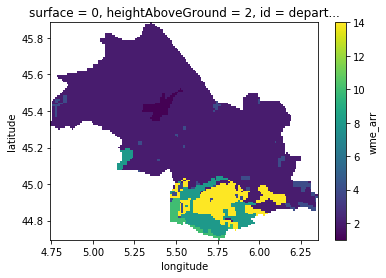

In [26]:
if windows: 
    dir_in = 'C:\\Users\\mary\\Desktop\\stageemi\\WWMF\\' 
    fname = Path(dir_in +  date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc')
else:    
    dir_in = '/scratch/labia/lepapeb/StageEMI/WWMF/'
    fname  = dir_in + date+'0000__PG0PAROME__'+'WWMF'+'__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc'
    
ds     = read_xarray(fname)

if mask_sympo and not mask_geographique: 
    ds2plot = ds.isel(step=echeance) * ds_mask.mask.sel(id='departement') 
if mask_geographique and not mask_sympo: 
    ds2plot = ds.isel(step=echeance) * ds_mask.mask.sel(id="mask") 
# ds2plot.unknown[ind] = 0 
ds_WME = conversion(ds2plot,name) 
# on regroupe 'Très nuageux/Couvert' et 'Nuageux'
ds_WME.wme_arr.values[(ds_WME.wme_arr.values == 2) 
                      + ((ds_WME.wme_arr.values == 3) )] = 2

# on regroupe ensemble neige (10) et neige faible (7)
ds_WME.wme_arr.values[(ds_WME.wme_arr.values == 7) 
                      + ((ds_WME.wme_arr.values == 10) )] = 10

# on regroupe ensemble pluie (8) et pluie faible (6)
ds_WME.wme_arr.values[(ds_WME.wme_arr.values == 6) 
                      + ((ds_WME.wme_arr.values == 8) )] = 8

# on regroupe ensemble qlqs averses (12) et averses (14), et qlqs averses de neige (13)
ds_WME.wme_arr.values[(ds_WME.wme_arr.values == 12) + (ds_WME.wme_arr.values == 13)
                      + ((ds_WME.wme_arr.values == 14) )] = 14


# on regroupe ensemble averses Orageuses (16) et Orages  (18)
ds_WME.wme_arr.values[(ds_WME.wme_arr.values == 16) + ((ds_WME.wme_arr.values == 18) )] = 18

# ds_WME.wme_arr.values[ds_WME.wme_arr.values<4] = 2 
# ds_WME.wme_arr.values[ds_WME.wme_arr.values>=4] = 3 

del(ds,ds2plot)
ds_WME.wme_arr.plot.imshow()

# on regarde les codes 
file_CodesWWMF = '../../utils/CodesWWMF.csv'
cible_list,legend_list = get_WME_legend(file_CodesWWMF, ds_WME)
print(cible_list,legend_list)

In [29]:
ds_mask.id.values.size

151

In [28]:
nsubzonesMax = 6
listCible    = cible_list[::-1]

listMasksNew = ds_mask.id.values # on commence avec l'ensemble des masks

# liste de zones sympos initiales (pour checker à la fin si oui ou non on a une info sur toutes les zones)
list_zones_sympos_initiales = [zone for zone in ds_mask.id.values if len(zone) == 4]

nsubzones    = 0
zones_cibles = {}
score_zones_cibles = {}
if len(listCible) == 0 : # si un département a le même temps sensible partout
    zones_cibles[listCible[0]] = 'departement'
else: 
    for icible,cible in enumerate(listCible):
        if nsubzones > nsubzonesMax: 
            print('nombre de sous-zones trop grand')
            break 
        if len(listMasksNew)>60:
            #  on regroupe les masks selon leur taille
            groupe1,groupe2,groupe3,taille1,taille2  = group_masks_size(listMasksNew,ds_mask)
            # on selectionne le groupement de zones qui match l'objet météo
            groupe_mask_select = select_group_mask(ds_WME,cible,groupe1,groupe2,groupe3,taille1,taille2)
        else: 
            # on considère l'ensemble des masks
            groupe_mask_select = ds_mask.mask.sel(id=listMasksNew)
        # on selectionne la zone optimale (selon le score souhaité)
#         print(groupe_mask_select.id.values)
        zones_optimales, scores_zones_optimales = get_optimal_subzone(ds_WME, groupe_mask_select,cible)
        score_zones_cibles[cible] = scores_zones_optimales['hss']
        
        """
            Check sur le critère d'homogénéité, car s'il est trop bas -> pas de zones existantes qui caractérise le phénoméne cible
        """
        if score_zones_cibles[cible]< 0 :
            print('pas de zones homogène pour {}'.format(cible))
            print(score_zones_cibles[cible])
            print()
            continue
        else : 
            zones_cibles[cible] = zones_optimales['hss']
            nsubzones +=1
            
        print(cible,zones_cibles[cible],score_zones_cibles[cible])

        '''
            on check que la somme des zones n'est pas deja egale au departement
        '''
        if  nsubzones== 1 : 
            ds_temp  = ds_mask.sel(id=zones_cibles[cible]).mask.copy()
        else: 
            ds_temp.values[(ds_temp.values == 1) + (ds_mask.sel(id=zones_cibles[cible]).mask.values ==1) ] = 1

        somme = np.sum((ds_temp.values == 1)&( ds_mask.sel(id='departement').mask.values== 1))
        tailleDep = np.sum( ds_mask.sel(id='departement').mask.values== 1)
        if somme == tailleDep: 
            print('on a atteint la taille du departement')
            break
        listMasksNew, lst_mask_included = get_not_included_masks(ds_mask.mask.sel(id=zones_optimales['hss'])
                                        ,listMasksNew,ds_mask,flag_strictly_included=False)
#         nsubzones += 1 

    '''
        on vérifie que toutes les zones du département sont dans les zones sympos
    '''
    list_zones_select = [zones_cibles[cible] for cible in zones_cibles.keys()]
    zones_restantes = []
    for zone_sympo in list_zones_sympos_initiales:
        n = 0
        for zone_select in list_zones_select: 
    #         print(zone,zone_select)
            if zone_sympo in zone_select:
                n+=1
        if n == 0 : 
            zones_restantes.append(zone_sympo)
    if len(zones_restantes) > 0: 
#         print(len(zones_restantes))
        print('zones restantes:',zones_restantes)
    else:
        print('toutes les zones sont bien décrites')
        
print(zones_cibles)    

3207.0 6292.0
objet dans groupe 1
14.0 3803 0.4664535602300041
151
2595.0 5712.0
objet dans groupe 1
10.0 3806 0.18378343790961196
64
8.0 3808 0.040885145345231334
35
4.0 3801 0.13770643811645694
19
2.0 3802+3804+3805+3807 0.4768740275525858
on a atteint la taille du departement
toutes les zones sont bien décrites
{14.0: '3803', 10.0: '3806', 8.0: '3808', 4.0: '3801', 2.0: '3802+3804+3805+3807'}


# pour brancher l'agrégation 

In [31]:
# ds_WME.latitude.values = ds_WME.latitude.values[::-1]
# print(d)
# ds_WME.wme_arr.plot()

for cible in zones_cibles.keys():
    zone_select = zones_cibles[cible] 
    ds_zone = ds_WME * ds_mask.mask.sel(id=zone_select)#ds_WME.wme_arr.where(ds_mask.mask.sel(id=zone).values==1,drop=True)

    ds_zone.wme_arr.values[ds_zone.wme_arr.values == 0] = np.nan
    ds = calculate_distance(ds_zone,name)
    print(zone_select,cible,ds.attrs[name])
# dist_w[0]=np.asarray([np.sum(ds[w].isel(step=istep)) for iw,w in enumerate(list_w)])
        

KeyError: 'w1_arr'

In [30]:
name='agat'
for cible in zones_cibles.keys():
    zone_select = zones_cibles[cible] 
    ds_zone = ds_WME * ds_mask.mask.sel(id=zone_select)#ds_WME.wme_arr.where(ds_mask.mask.sel(id=zone).values==1,drop=True)

    ds_zone.wme_arr.values[ds_zone.wme_arr.values == 0] = np.nan
    ds = calculate_distance(ds_zone,name)
    print(zone_select,cible,ds.attrs[name])
# dist_w[0]=np.asarray([np.sum(ds[w].isel(step=istep)) for iw,w in enumerate(list_w)])
        

KeyError: 'w1_arr'

In [ ]:

a = [1,2,3,4]
b = [4,5,6,7]
a.join(b)

In [ ]:
len('3801')

In [ ]:
file_CodesWWMF = '../../utils/CodesWWMF.csv'
cible_list,legend_list = get_WME_legend(file_CodesWWMF, ds_WME)
print(cible_list,legend_list)
somme = [np.sum(ds_WME.wme_arr.values == cible) for cible in cible_list]
print(somme)

# old 

In [ ]:
# idee 1: on parcourt lensemble des temps sensibles et on regarde les zones associées aux WMEs
# On ne recupere que les zones pour lesquelles les valeurs des hss sont suffisants. 
# cible = 10
zones_cibles = {}
score_zones_cibles = {}
for icible,cible in enumerate(cible_list):
    '''
         taille de l'objet meteo et selection du groupe (ou pas ? )
    '''
    taille_objet_binaire = np.sum(ds_WME.wme_arr.values==cible)
#     print('taille objet binaire ', taille_objet_binaire)
    if taille_objet_binaire < taille1 and taille_objet_binaire >0: # groupe 1 de masks
#         print('objet dans groupe 1')
        groupe_mask_select = groupe1

    elif taille_objet_binaire>=taille1 and taille_objet_binaire < taille2: # groupe 2 de mask
#         print('objet dans groupe 2')
        groupe_mask_select = groupe2
    else :
        # On parcourt la liste de mask, calcul dun critere d'homogeneite dans le groupe 
#         print('objet dans groupe 3')
        groupe_mask_select = groupe3

    zones_optimales, scores_zones_optimales= get_optimal_subzone(ds_WME, groupe_mask_select,cible)
    zones_cibles[cible] = zones_optimales['hss']
    score_zones_cibles[cible] = scores_zones_optimales['hss']

    if score_zones_cibles[cible]< 0.2: 
        # aucun mask ne permet de bien représenter cette zone 
        continue 
    print('cible ' + str(cible) +' '+ legend_list[icible])    
    print('zone: {}, hss:{}'.format(zones_optimales['hss'], np.around(scores_zones_optimales['hss'],2)))
    print()
    
    
    